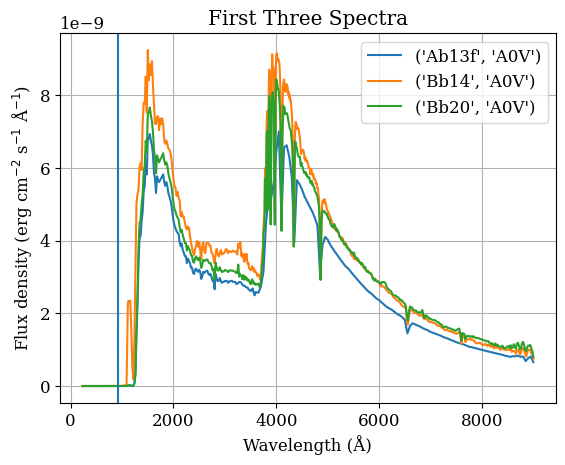

In [3]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import os
from astropy.io import fits
import pandas as pd

plt.rc('font', family='serif')  # Use a serif font
plt.rc('font', size=12)  # Set font size

# Read the spectra_list
spectra_list = Table.read(fr"spectra_list.csv", format ="ascii.csv")


filenames = spectra_list['filename']
types = spectra_list['type']

spectra = [Table.read(fr"spectra\{filename}", format ="ascii.csv") for filename in filenames]


wavelengths_list = [data['wavelength'] for data in spectra]
fluxes_list = [data['flux'] for data in spectra]


# Loop through 
indices = np.linspace(0, len(filenames) - 1, 3, dtype=int)
#for i in indices:
for i in range(3):
    # Filter data where wavelength is between 3000 and 9000
    mask = (wavelengths_list[i] >= 0) & (wavelengths_list[i] <= 9000)
    plt.plot(wavelengths_list[i][mask], fluxes_list[i][mask], label=(os.path.splitext(filenames[i])[0], types[i]))


plt.axvline(912)
# Adding labels and title
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux density (erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$)')
plt.title('First Three Spectra')
plt.legend()  
plt.grid(True)

plt.savefig('pdf\First_Three_Spectra1.pdf', format='pdf')

# Show the plot
plt.show()

In [3]:
# Problem 2

print('An angstrom is 10^-10 m')
print('A unit is W/m^2 or a jansky.')

An angstrom is 10^-10 m
A unit is W/m^2 or a jansky.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


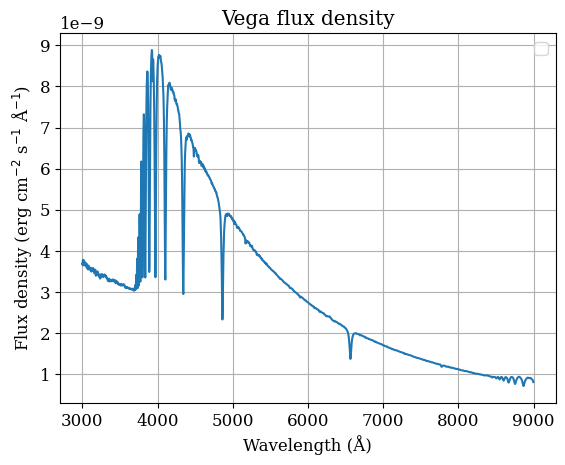

2.831857840725187e-06
5.616538099133372e-06
3.2782533051349564e-06
2.831857840725187e-06
5.616538099133372e-06
3.2782533051349564e-06
2.831857840725187e-06
5.616538099133372e-06
3.2782533051349564e-06
2.831857840725187e-06
5.616538099133372e-06
3.2782533051349564e-06
2.831857840725187e-06
5.616538099133372e-06
3.2782533051349564e-06
2.831857840725187e-06
5.616538099133372e-06
3.2782533051349564e-06
2.831857840725187e-06
5.616538099133372e-06
3.2782533051349564e-06
2.831857840725187e-06
5.616538099133372e-06
3.2782533051349564e-06
2.831857840725187e-06
5.616538099133372e-06
3.2782533051349564e-06
2.831857840725187e-06
5.616538099133372e-06
3.2782533051349564e-06
2.831857840725187e-06
5.616538099133372e-06
3.2782533051349564e-06
2.831857840725187e-06
5.616538099133372e-06
3.2782533051349564e-06
2.831857840725187e-06
5.616538099133372e-06
3.2782533051349564e-06
2.831857840725187e-06
5.616538099133372e-06
3.2782533051349564e-06
2.831857840725187e-06
5.616538099133372e-06
3.2782533051349564

In [4]:
# Problem 3

#data = fits.getdata("file.fits")



vega_path = fr'vega_fnu.csv'
#Notice: For this spectrum, the wavelength is given in nanometers and the flux density in erg cm-2 s-1 Hz-1.

def convert_flux_density(flux_vega, wavelength ):
    """Convert from erg cm^-2 s^-1 Hz^-1 to erg cm^-2 s^-1 Å^-1"""
    return flux_vega * (3e18 / wavelength**2)

def calculate_magnitude(star_flux, vega_flux):
    """Calculate the magnitude in a band."""
    return -2.5 * np.log10(star_flux / vega_flux)


vega_spectrum = Table.read(vega_path, format ="ascii.csv") 

vega_wavelength = vega_spectrum['wavelength'] * 10 # nanometers to angstrom
vega_flux_density = vega_spectrum['flux'] 

vega_converted_flux_density = convert_flux_density(vega_flux_density, vega_wavelength)


# Filter data where wavelength is between 3000 and 9000
mask = (vega_wavelength >= 3000) & (vega_wavelength <= 9000)
plt.plot(vega_wavelength[mask], vega_converted_flux_density[mask])

# Adding labels and title
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux density (erg cm$^{-2}$ s$^{-1}$ Å$^{-1}$)')
plt.title('Vega flux density')
plt.legend()  
plt.grid(True)



plt.savefig('pdf/vega_spectrum.pdf')
# Show the plot
plt.show()

# We see vega lines up decently with what we expect

# Now we need to integrate the flux density with the correct bounds for the different filters.
# U, B, V bands
filters = {
    'U': {'lambda_0': 3659, 'delta_lambda': 660, 'color': 'violet'},
    'B': {'lambda_0': 4582, 'delta_lambda': 940, 'color': 'blue' },
    'V': {'lambda_0': 5448, 'delta_lambda': 880, 'color': 'green'}
}


# Placeholder for the dictionary to store magnitudes
stars_data = {filename: {} for filename in filenames}

# Loop through each star

# Before we can use this, we must see that the steps are too large for these bounds. The steps between our measurements are 20, so we would first like to interpolatre this to get a more continious function.
for filename, star_type, wavelength, flux_density in zip(filenames,types, wavelengths_list, fluxes_list):
    star_magnitudes = {}
    
    for band, filter_data in filters.items():
        lambda_min = filter_data['lambda_0'] - filter_data['delta_lambda'] / 2
        lambda_max = filter_data['lambda_0'] + filter_data['delta_lambda'] / 2

        # Interpolate the flux within the B-band range
        band_wavelengths = np.linspace(lambda_min, lambda_max, 100)
        band_flux_density = np.interp(band_wavelengths, wavelength, flux_density)


        # Interpolate the flux within the B-band range
        band_vega_wavelengths = np.linspace(lambda_min, lambda_max, 100)
        band_vega_converted_flux_density = np.interp(band_wavelengths, vega_wavelength, vega_converted_flux_density)

        #plt.plot(band_wavelengths, band_flux_density, label=band, color=filter_data['color'])

        # Integrate flux over the wavelength range
        star_flux_integrated = np.trapz(band_flux_density, band_wavelengths)
        vega_flux_integrated = np.trapz(band_vega_converted_flux_density, band_vega_wavelengths)
        print(vega_flux_integrated)
        #print(star_flux_integrated, vega_flux_integrated)
        # Calculate magnitude
        magnitude = calculate_magnitude(star_flux_integrated, vega_flux_integrated)
        #print(f"{band}-band magnitude: {magnitude}")
        star_magnitudes[band] = magnitude

    # Store magnitudes in the dictionary
    stars_data[filename] = star_magnitudes



In [5]:


df = pd.DataFrame.from_dict(stars_data, orient='index')

df['type'] = types
# Calculate U-B and B-V
df['U-B'] = df['U'] - df['B']
df['B-V'] = df['B'] - df['V']


# Reorder columns to put 'type' first
columns_order = ['type', 'U', 'B', 'V', 'U-B', 'B-V']
df = df[columns_order]

# Adjust display settings to show all rows and columns
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Auto-detect width for better formatting

#print(df)

type_order = ['O', 'B', 'A', 'F', 'G', 'K', 'M']


# Create a mapping for sorting based on the first character of the type
df['type_order'] = df['type'].str[0].map({t: i for i, t in enumerate(type_order)})
# Split the DataFrame into two based on the last character of 'type'
df_I = df[df['type'].str.endswith('I')].copy()

# Create columns for sorting: one for the letter and one for the number
df_I['letter'] = df_I['type'].str[0]  # First character
df_I['number'] = df_I['type'].str[1:-1].astype(int)  # Numeric part as integer

# Sort the DataFrame based on the custom order
df_I.sort_values(by=['type_order', 'number'], inplace=True)

# Drop the auxiliary columns since they are no longer needed
df_I = df_I.drop(columns=['type_order', 'letter', 'number'])


df_I = df_I.round(2)
# Convert the DataFrame to LaTeX table format
latex_table = df_I.to_latex(index=False)

# Save it to a .tex file
with open('latex\giants_table.tex', 'w') as f:
    f.write(latex_table)
    
print(latex_table)
# Split the DataFrame into two based on the last character of 'type'
df_V = df[df['type'].str.endswith('V')].copy()

# Create columns for sorting: one for the letter and one for the number
df_V['letter'] = df_V['type'].str[0]  # First character
df_V['number'] = df_V['type'].str[1:-1].astype(int)  # Numeric part as integer

# Sort the DataFrame based on the custom order
df_V.sort_values(by=['type_order', 'number'], inplace=True)

# Drop the auxiliary columns since they are no longer needed
df_V = df_V.drop(columns=['type_order', 'letter', 'number'])


df_V = df_V.round(2)

# Convert the DataFrame to LaTeX table format
latex_table = df_V.to_latex(index=False)

# Save it to a .tex file
with open('latex\main_sequence_table.tex', 'w') as f:
    f.write(latex_table)
    
print(latex_table)



\begin{tabular}{lrrrrr}
\toprule
type &     U &     B &     V &   U-B &   B-V \\
\midrule
 O7I & -8.03 & -6.89 & -6.72 & -1.14 & -0.17 \\
 O9I & -8.03 & -6.89 & -6.72 & -1.13 & -0.17 \\
 B0I & -7.92 & -6.85 & -6.72 & -1.08 & -0.13 \\
 B1I & -7.79 & -6.81 & -6.72 & -0.98 & -0.09 \\
 B5I & -7.57 & -6.83 & -6.82 & -0.74 & -0.01 \\
 B8I & -7.52 & -6.98 & -7.02 & -0.54 &  0.03 \\
 A2I & -7.45 & -7.15 & -7.22 & -0.30 &  0.07 \\
 F0I & -6.73 & -6.94 & -7.12 &  0.21 &  0.18 \\
 F2I & -6.66 & -6.91 & -7.12 &  0.24 &  0.21 \\
 F8I & -6.03 & -6.43 & -6.81 &  0.40 &  0.38 \\
 G0I & -5.67 & -6.28 & -6.81 &  0.61 &  0.53 \\
 G2I & -5.29 & -6.08 & -6.71 &  0.78 &  0.63 \\
 G8I & -4.48 & -5.77 & -6.61 &  1.29 &  0.84 \\
 M1I & -2.21 & -4.63 & -6.08 &  2.41 &  1.45 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrr}
\toprule
type &     U &     B &     V &   U-B &   B-V \\
\midrule
 O5V & -8.15 & -6.92 & -6.72 & -1.23 & -0.20 \\
 O7V & -7.54 & -6.32 & -6.12 & -1.21 & -0.20 \\
 O8V & -6.91 & -5.72 & -5

C:\Users\damia\AppData\Local\Temp\ipykernel_19292\412540076.py:41: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_I.to_latex(index=False)
C:\Users\damia\AppData\Local\Temp\ipykernel_19292\412540076.py:65: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_V.to_latex(index=False)


In [6]:
mean_bv = df.groupby('type')['B-V'].mean()
mean_bv.to_csv('mean_bv.csv')
print(mean_bv)

type
A0V    0.010239
A1V    0.010821
A2I    0.073029
A2V    0.017663
A3V    0.036104
A5V    0.116673
A7V    0.096800
B0I   -0.128103
B0V   -0.211242
B1I   -0.092038
B1V   -0.201695
B2V   -0.189376
B3V   -0.124844
B5I   -0.012111
B5V   -0.105727
B6V   -0.093491
B7V   -0.084539
B8I    0.034839
B8V   -0.054230
B9V   -0.027125
F0I    0.180333
F2I    0.211504
F2V    0.272156
F4V    0.219100
F5V    0.328404
F6V    0.315589
F7V    0.362027
F8I    0.384879
F8V    0.383015
F9V    0.404096
G0I    0.528272
G0V    0.412689
G1V    0.456847
G2I    0.630223
G2V    0.447277
G5V    0.492636
G8I    0.836511
G8V    0.562876
K0V    0.543982
K3V    0.684181
K4V    0.693579
K5V    0.868615
K7V    1.011866
K8V    0.754849
K9V    1.037977
M0V    1.058941
M1I    1.453099
M1V    1.149093
M2V    1.176031
M4V    1.209478
M5V    1.158015
M6V    1.379054
M8V    1.058665
O5V   -0.202407
O7I   -0.171459
O7V   -0.200058
O8V   -0.195361
O9I   -0.172542
O9V   -0.212434
Name: B-V, dtype: float64


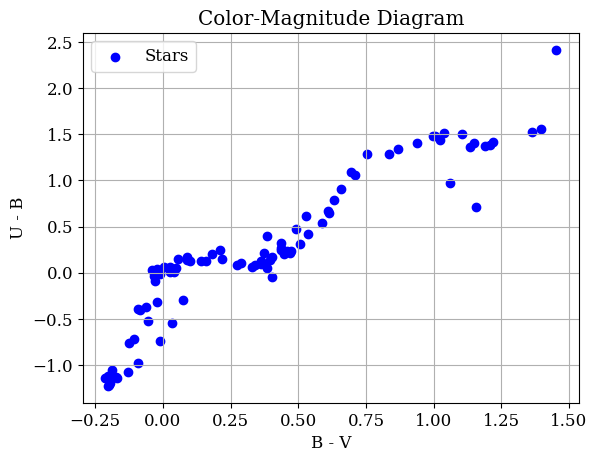

In [7]:
plt.scatter(df['B-V'], df['U-B'], c='blue', label='Stars')
plt.ylabel('U - B')
plt.xlabel('B - V')
plt.title('Color-Magnitude Diagram')
plt.grid(True)
plt.legend()
plt.show()

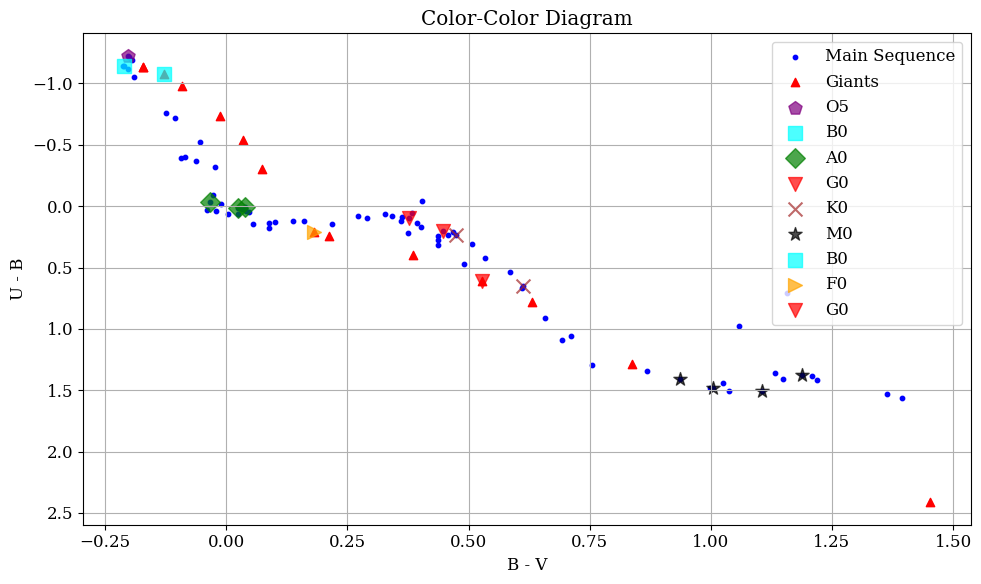

In [8]:


# Filter data by type
spectral_types = ["O5", "B0", "A0", "F0", "G0", "K0", "M0"]
main_sequence = df[df['type'].str.contains("V")]
giants = df[df['type'].str.contains("I")]


# Function to plot and label specific spectral types
def plot_spectral_types(df, spectral_types, color_dict):
    for spec_type in spectral_types:
        # Filter stars of this spectral type
        stars = df[df['type'].str.contains(spec_type)]
        if not stars.empty:
            # Plot the spectral type
            plt.scatter(stars['B-V'], stars['U-B'], label=f'{spec_type}', color=color_dict.get(spec_type), marker=shape_dict.get(spec_type), s=100,alpha=0.7)
            # Optionally add text labels for these stars
            # for index, row in stars.iterrows():
            #     plt.text(row['B-V'], row['U-B'], row['type'], fontsize=9, ha='right', color='black')

# Color dictionary for spectral types
color_dict = {
    "O5": 'purple',
    "B0": 'cyan',
    "A0": 'green',
    "F0": 'orange',
    "G0": 'red',
    "K0": 'brown',
    "M0": 'black'
}

shape_dict = {
    "O5": 'p',    # Circle
    "B0": 's',    # Square
    "A0": 'D',    # Diamond
    "F0": '>',    # Triangle (up)
    "G0": 'v',    # Triangle (down)
    "K0": 'x',    # Cross
    "M0": '*'     # Star
}

# Plot U-B vs B-V
plt.figure(figsize=(10, 6))

# Plot Main Sequence Stars
plt.scatter(main_sequence['B-V'], main_sequence['U-B'], label='Main Sequence', s=10, c='blue', marker='o')

# Plot Giants
plt.scatter(giants['B-V'], giants['U-B'], label='Giants', c='red', marker='^')

# Plot and label specific spectral types
plot_spectral_types(main_sequence, spectral_types, color_dict)
plot_spectral_types(giants, spectral_types, color_dict)

# Add labels and legend
plt.xlabel('B - V')
plt.ylabel('U - B')
plt.gca().invert_yaxis()
plt.title('Color-Color Diagram')
plt.legend(loc='upper right')
plt.grid(True) 
plt.tight_layout()

plt.savefig('pdf/cc_diagram.pdf')
plt.show()


DataFrame with types ending in 'V':
   type       B-V
53  O5V -0.202407
55  O7V -0.200058
56  O8V -0.195361
58  O9V -0.212434
8   B0V -0.211242
10  B1V -0.201695
11  B2V -0.189376
12  B3V -0.124844
14  B5V -0.105727
15  B6V -0.093491
16  B7V -0.084539
18  B8V -0.054230
19  B9V -0.027125
0   A0V  0.010239
1   A1V  0.010821
3   A2V  0.017663
4   A3V  0.036104
5   A5V  0.116673
6   A7V  0.096800
22  F2V  0.272156
23  F4V  0.219100
24  F5V  0.328404
25  F6V  0.315589
26  F7V  0.362027
28  F8V  0.383015
29  F9V  0.404096
31  G0V  0.412689
32  G1V  0.456847
34  G2V  0.447277
35  G5V  0.492636
37  G8V  0.562876
38  K0V  0.543982
39  K3V  0.684181
40  K4V  0.693579
41  K5V  0.868615
42  K7V  1.011866
43  K8V  0.754849
44  K9V  1.037977
45  M0V  1.058941
47  M1V  1.149093
48  M2V  1.176031
49  M4V  1.209478
50  M5V  1.158015
51  M6V  1.379054
52  M8V  1.058665


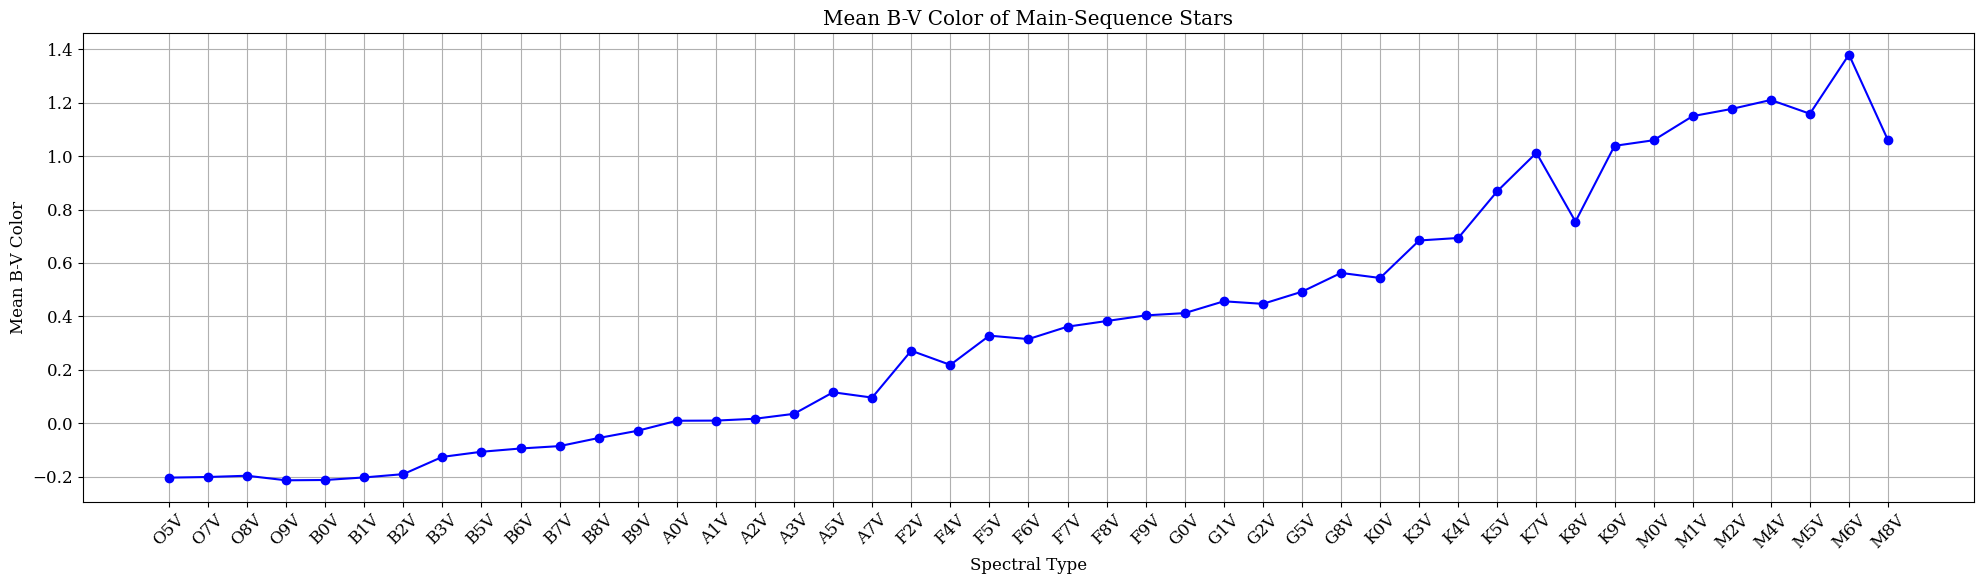

DataFrame with types ending in 'I':
   type       B-V
54  O7I -0.171459
57  O9I -0.172542
7   B0I -0.128103
9   B1I -0.092038
13  B5I -0.012111
17  B8I  0.034839
2   A2I  0.073029
20  F0I  0.180333
21  F2I  0.211504
27  F8I  0.384879
30  G0I  0.528272
33  G2I  0.630223
36  G8I  0.836511
46  M1I  1.453099


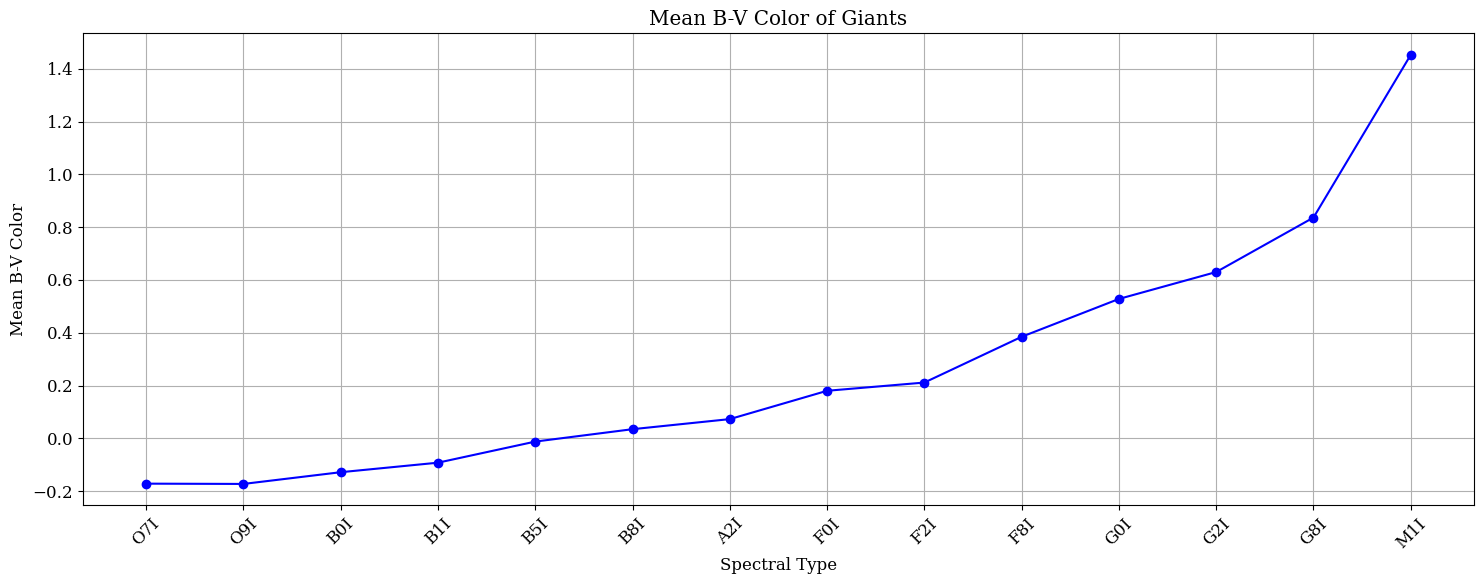

In [9]:
import pandas as pd
mean_bv = pd.read_csv('mean_bv.csv', index_col=0)  # 'index_col=0' to keep the 'type' as index

# Reset the index to move 'type' to a regular column
mean_bv = mean_bv.reset_index()
#print(mean_bv)

# Define the order of the types
type_order = ['O', 'B', 'A', 'F', 'G', 'K', 'M']

# Create a mapping for sorting based on the first character of the type
mean_bv['type_order'] = mean_bv['type'].str[0].map({t: i for i, t in enumerate(type_order)})

# Split the DataFrame into two based on the last character of 'type'
df_V = mean_bv[mean_bv['type'].str.endswith('V')].copy()

# Create columns for sorting: one for the letter and one for the number
df_V['letter'] = df_V['type'].str[0]  # First character
df_V['number'] = df_V['type'].str[1:-1].astype(int)  # Numeric part as integer

# Sort the DataFrame based on the custom order
df_V.sort_values(by=['type_order', 'number'], inplace=True)

# Drop the auxiliary columns since they are no longer needed
df_V = df_V.drop(columns=['type_order', 'letter', 'number'])

# Display the sorted DataFrame
print("DataFrame with types ending in 'V':")
print(df_V)


# Plotting
plt.figure(figsize=(20, 6))
plt.plot(df_V['type'], df_V['B-V'], marker='o', linestyle='-', color='b')
plt.title('Mean B-V Color of Main-Sequence Stars')
plt.xlabel('Spectral Type')
plt.ylabel('Mean B-V Color')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('pdf/mean_bv_main.pdf')
plt.show()


# Split the DataFrame into two based on the last character of 'type'
df_I = mean_bv[mean_bv['type'].str.endswith('I')].copy()

# Create columns for sorting: one for the letter and one for the number
df_I['letter'] = df_I['type'].str[0]  # First character
df_I['number'] = df_I['type'].str[1:-1].astype(int)  # Numeric part as integer

# Sort the DataFrame based on the custom order
df_I.sort_values(by=['type_order', 'number'], inplace=True)

# Drop the auxiliary columns since they are no longer needed
df_I = df_I.drop(columns=['type_order', 'letter', 'number'])

# Display the sorted DataFrame
print("DataFrame with types ending in 'I':")
print(df_I)


# Plotting
plt.figure(figsize=(15, 6))
plt.plot(df_I['type'], df_I['B-V'], marker='o', linestyle='-', color='b')
plt.title('Mean B-V Color of Giants')
plt.xlabel('Spectral Type')
plt.ylabel('Mean B-V Color')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('pdf/mean_bv_giants.pdf')
plt.show()


       Temperature          U          B          V       U-B       B-V
0      2000.000000 -22.963290 -25.595653 -27.774821  2.632363  2.179168
1      2007.847233 -23.044064 -25.660264 -27.830020  2.616200  2.169756
2      2015.725255 -23.124534 -25.724632 -27.885008  2.600098  2.160376
3      2023.634187 -23.204701 -25.788760 -27.939787  2.584059  2.151027
4      2031.574151 -23.284567 -25.852648 -27.994358  2.568081  2.141710
5      2039.545268 -23.364132 -25.916296 -28.048720  2.552164  2.132424
6      2047.547661 -23.443398 -25.979706 -28.102876  2.536309  2.123169
7      2055.581452 -23.522365 -26.042879 -28.156825  2.520514  2.113946
8      2063.646765 -23.601035 -26.105815 -28.210569  2.504780  2.104753
9      2071.743723 -23.679409 -26.168516 -28.264108  2.489106  2.095592
10     2079.872451 -23.757488 -26.230981 -28.317443  2.473493  2.086462
11     2088.033072 -23.835273 -26.293212 -28.370574  2.457939  2.077362
12     2096.225712 -23.912766 -26.355211 -28.423504  2.442445  2

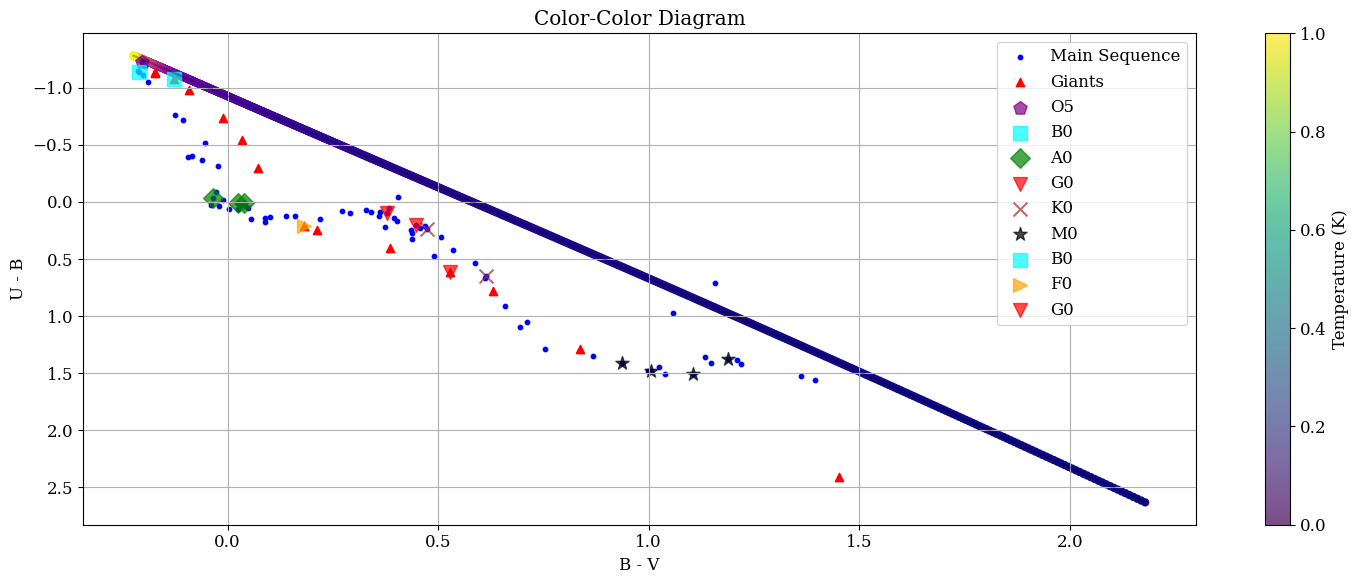

In [10]:
from astropy.constants import c, h, k_B
def blackbody_flux(wavelength, temperature):
    """Calculate blackbody flux at a given wavelength and temperature.

       wavelenth : input is in angstrom
       temperature: in Kelvin
       
       we need to convert from standard units... to ... 
    """
    # Convert wavelength from Ångströms to meters
    wavelength_m = wavelength * (1e-10)
    # Calculate the exponent for Planck's law (dimensionless)
    exponent = (h.value * c.value) / (wavelength_m * k_B.value * temperature)
    # Planck's la  w formula
    flux = (2 * h.value * c.value**2) / (wavelength_m**5 * (np.exp(exponent) - 1))
    # flux in W·m⁻²·m⁻¹·sr⁻¹ to  erg *cm^-2 * A^-1 * sr^-1
    flux_converted = flux * 10**-7
    return flux_converted



def calculate_blackbody_magnitude(temperature, band):
    """Calculate the magnitude for a black body in a given band."""
    # Define the band limits
    lambda_min = filters[band]['lambda_0'] - filters[band]['delta_lambda'] / 2
    lambda_max = filters[band]['lambda_0'] + filters[band]['delta_lambda'] / 2
    
    band_wavelengths = np.linspace(lambda_min, lambda_max, 100)
    # Calculate blackbody flux density
    band_flux_density = blackbody_flux(band_wavelengths, temperature)
    #plt.plot(band_wavelengths, band_flux_density)
    # Integrate the flux over the band range


    # Interpolate the flux within the B-band range
    band_vega_wavelengths = np.linspace(lambda_min, lambda_max, 100)
    band_vega_converted_flux_density = np.interp(band_wavelengths, vega_wavelength, vega_converted_flux_density)

    blackbody_flux_integrated = np.trapz(band_flux_density, band_wavelengths)
    vega_flux_integrated = np.trapz(band_vega_converted_flux_density, band_vega_wavelengths)
    
    magnitude = calculate_magnitude(blackbody_flux_integrated, vega_flux_integrated)

    # Calculate the magnitude
    return magnitude


# Define temperature range
temperatures = np.logspace(3.301, 4.477, 100)  # From 2000 K to 30000 K

start_temp = 2000
stop_temp = 100000
num_points=1000
# Create evenly spaced points in the exponent using base e
logspace_temperatures = np.linspace(np.log(start_temp), np.log(stop_temp), num_points)

# Convert back to the actual temperature values using the exponential function
temperatures = np.exp(logspace_temperatures)

bands = 'U' , 'B' , 'V'

# Create a dictionary to hold the results
results = {}

# Loop through temperatures and bands, calculating the magnitude
for temperature in temperatures:
    magnitudes = []
    for band in bands:
        magnitude = calculate_blackbody_magnitude(temperature, band)
        magnitudes.append(magnitude)
    results[temperature] = magnitudes

# Create a DataFrame from the results
df_temp = pd.DataFrame.from_dict(results, orient='index', columns=bands)

# Reset the index to have Temperature as a column
df_temp.reset_index(inplace=True)
df_temp.rename(columns={'index': 'Temperature'}, inplace=True)

# Calculate U-B and B-V color indices
df_temp['U-B'] = df_temp['U'] - df_temp['B']
df_temp['B-V'] = df_temp['B'] - df_temp['V']


# Display the DataFrame
print(df_temp)

plt.figure(figsize=(15, 6))

plt.scatter(df_temp['B-V'] , df_temp['U-B'], c=temperatures, cmap='plasma', edgecolor='none')
plt.plot(df_temp['B-V'] , df_temp['U-B'], color='black', alpha=0.3)
# Plot U-B vs B-V


# Plot Main Sequence Stars
plt.scatter(main_sequence['B-V'], main_sequence['U-B'], label='Main Sequence', s=10, c='blue', marker='o')

# Plot Giants
plt.scatter(giants['B-V'], giants['U-B'], label='Giants', c='red', marker='^')

# Plot and label specific spectral types
plot_spectral_types(main_sequence, spectral_types, color_dict)
plot_spectral_types(giants, spectral_types, color_dict)

# Add labels and legend
cbar = plt.colorbar()
cbar.set_label('Temperature (K)')

plt.xlabel('B - V')
plt.ylabel('U - B')
plt.gca().invert_yaxis()
plt.title('Color-Color Diagram')
plt.legend()
plt.grid(True) 
plt.tight_layout()
plt.savefig('pdf/cc_diagram_blackbody.pdf')
plt.show()

The B-V value for type B0V is -0.2112416101203784
 The corresponding temperature is 72251.07845581148
The B-V value for type A0V is 0.0102387362567892
 The corresponding temperature is 14169.852619214495
The B-V value for type F0I is 0.1803332488209097
 The corresponding temperature is 9392.796480079161
The B-V value for type G0V is 0.412688889888352
 The corresponding temperature is 6577.091455991117


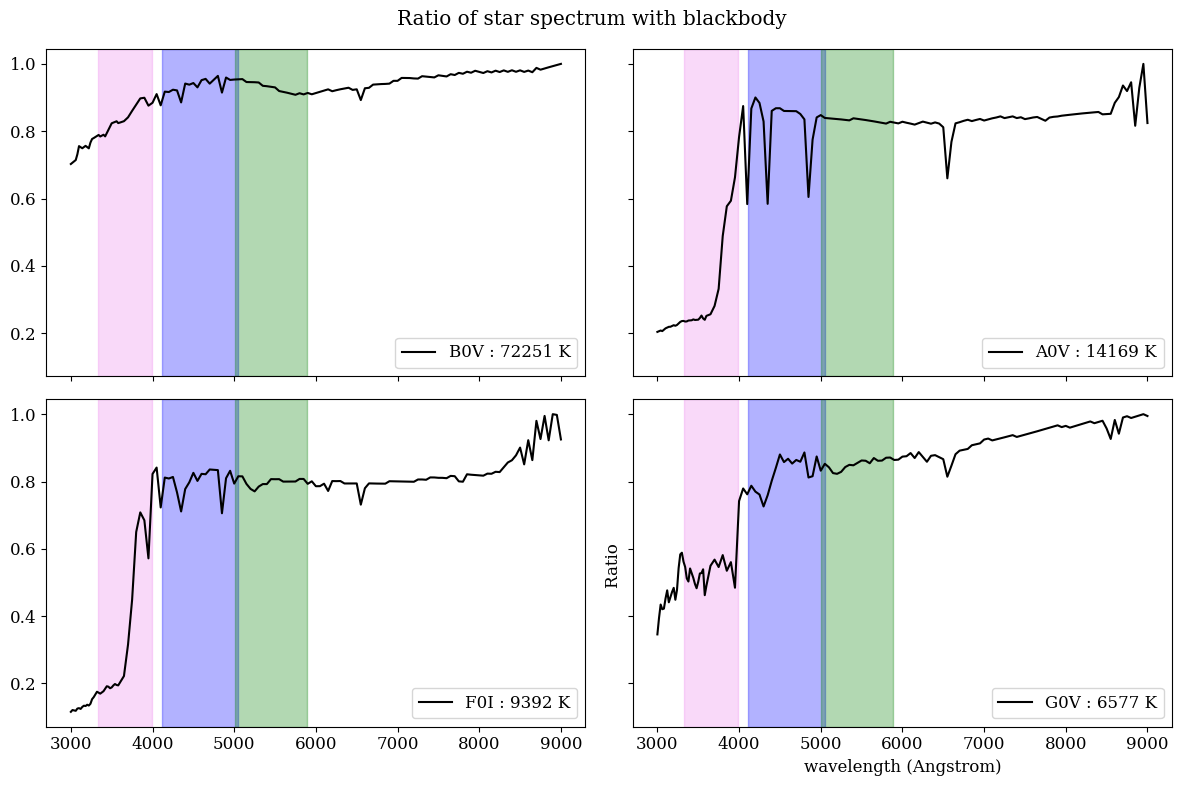

In [40]:
types_to_test = ['B0V', 'A0V', 'F0I', 'G0V']
# Create a figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

# Flatten the axes for easier iteration
axs = axs.ravel()

filters = {
    'U': {'lambda_0': 3659, 'delta_lambda': 660, 'color': 'violet'},
    'B': {'lambda_0': 4582, 'delta_lambda': 940, 'color': 'blue' },
    'V': {'lambda_0': 5448, 'delta_lambda': 880, 'color': 'green'}
}


colors = ['violet', 'blue', 'green']
# Access the B-V value for type A0
for i, type_to_test in enumerate(types_to_test):
    type_BV= (df_V.loc[df_V['type'] == type_to_test, 'B-V'])
    if type_to_test == 'F0I':
        type_BV= (df_I.loc[df_I['type'] == type_to_test, 'B-V'])
    
    type_BV= float(type_BV)
    print(f'The B-V value for type {type_to_test} is {type_BV}')


    # Find the row where the B-V value is closest to the A0V B-V value
    closest_index = (df_temp['B-V'] - type_BV).abs().idxmin()

    # Get the corresponding temperature
    closest_temperature = df_temp.loc[closest_index, 'Temperature']
    print(f' The corresponding temperature is {closest_temperature}')
    index = np.where(np.asarray(types) == type_to_test)
    first_index = index[0][0]

    mask = (wavelengths_list[first_index] >= 3000) & (wavelengths_list[first_index] <= 9000)
    blackbody_spectrum  = blackbody_flux(wavelengths_list[first_index][mask],closest_temperature)

    ratio = fluxes_list[first_index][mask] / blackbody_spectrum     
    # Plot the data in the respective subplot
    axs[i].plot(wavelengths_list[first_index][mask], ratio / np.max(ratio), 
                label=f'{type_to_test} : {int(closest_temperature)} K', color='black')

    #axs[i].set_title(f'{type_to_test}: {int(closest_temperature)} K')
    axs[i].legend(loc='lower right')

    for band, color in zip(bands, colors):
        lambda_min = filters[band]['lambda_0'] - filters[band]['delta_lambda'] / 2
        lambda_max = filters[band]['lambda_0'] + filters[band]['delta_lambda'] / 2

        axs[i].axvspan(lambda_min, lambda_max, alpha = 0.3, color=color)
    
    
    #plt.plot(wavelengths_list[first_index][mask],  (ratio / np.max(ratio)), label=f' {type_to_test} : {int(closest_temperature)} K' , color='black')





plt.suptitle('Ratio of star spectrum with blackbody')
#plt.yscale('log')
plt.xlabel('wavelength (Angstrom)')
plt.ylabel('Ratio ')    
plt.legend()
plt.tight_layout()
plt.savefig('pdf/divided_spectrum.pdf')
plt.show()









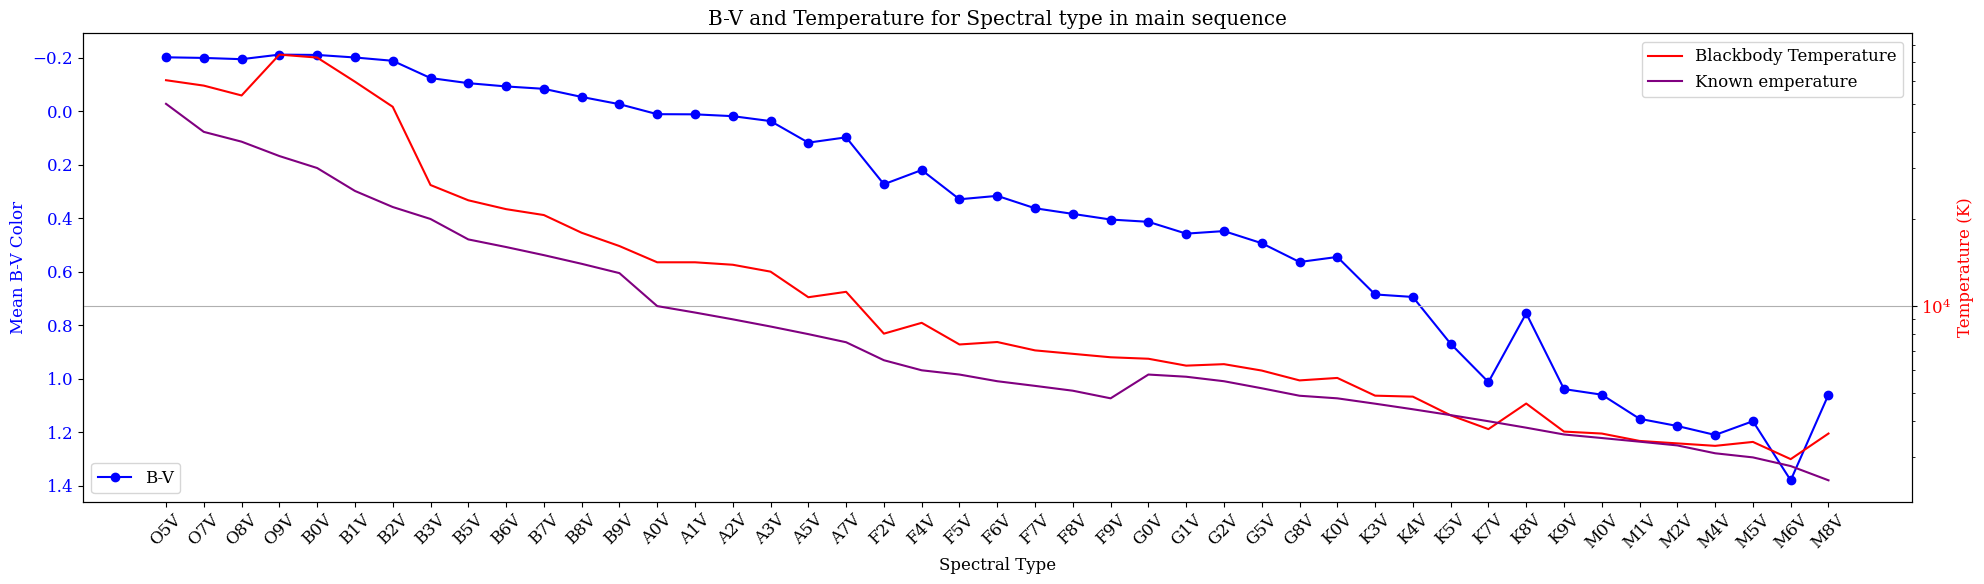

In [12]:
temperatures = []
for type in df_V['type']:
    type_BV= (df_V.loc[df_V['type'] == type, 'B-V'])
    type_BV = float(type_BV)
    #print(type_BV)
    # Find the row where the B-V value is closest to the A0V B-V value
    closest_index = (df_temp['B-V'] - type_BV).abs().idxmin()

    # Get the corresponding temperature
    closest_temperature = df_temp.loc[closest_index, 'Temperature']
    # Append the closest temperature to the list
    temperatures.append(closest_temperature)

# Assign the list of temperatures to a new column in df_V
df_V['temperature'] = temperatures

# Found online for our stars
temperatures_online = [50000, 40000, 37000, 33000, 30000, 25000, 22000, 20000, 17000, 16000, 15000, 14000, 13000, 10000, 9500, 9000, 8500, 8000, 7500, 6500, 6000, 5800, 5500, 5300, 5100, 4800, 5800, 5700, 5500, 5200, 4900, 4800, 4600, 4400, 4200, 4000, 3800, 3600, 3500, 3400, 3300, 3100, 3000, 2800, 2500]


# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot magnitude on the left y-axis
ax1.plot(df_V['type'], df_V['B-V'], marker='o', linestyle='-', color='b', label='B-V')
ax1.set_xlabel('Spectral Type')
ax1.set_ylabel('Mean B-V Color', color='b')
ax1.tick_params(axis='y', labelcolor='b')  # Change y-axis tick color

# Invert the y-axis for magnitude
ax1.invert_yaxis()

ax2 = ax1.twinx()
ax2.plot(df_V['type'], df_V['temperature'], color='r', label='Blackbody Temperature')
ax2.plot(df_V['type'], temperatures_online, color='purple', label='Known emperature')
ax2.set_ylabel('Temperature (K)', color='r')
ax2.tick_params(axis='y', labelcolor='r')  # Change y-axis tick color
ax2.set_yscale('log')  # Set y-axis to logarithmic scale

# Add title and show legend
plt.title('B-V and Temperature for Spectral type in main sequence')
ax1.legend(loc='lower left')
ax2.legend(loc='upper right')
#ax1.set_xticklabels(df_V['type'], rotation=45)
# Set x-ticks using the axis object
ax1.set_xticks(range(len(df_V['type'])))  # Set tick positions
ax1.set_xticklabels(df_V['type'])  # Set tick labels

# Rotate the tick labels
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)

plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('pdf/mean_bv_temp_main.pdf')
plt.show()

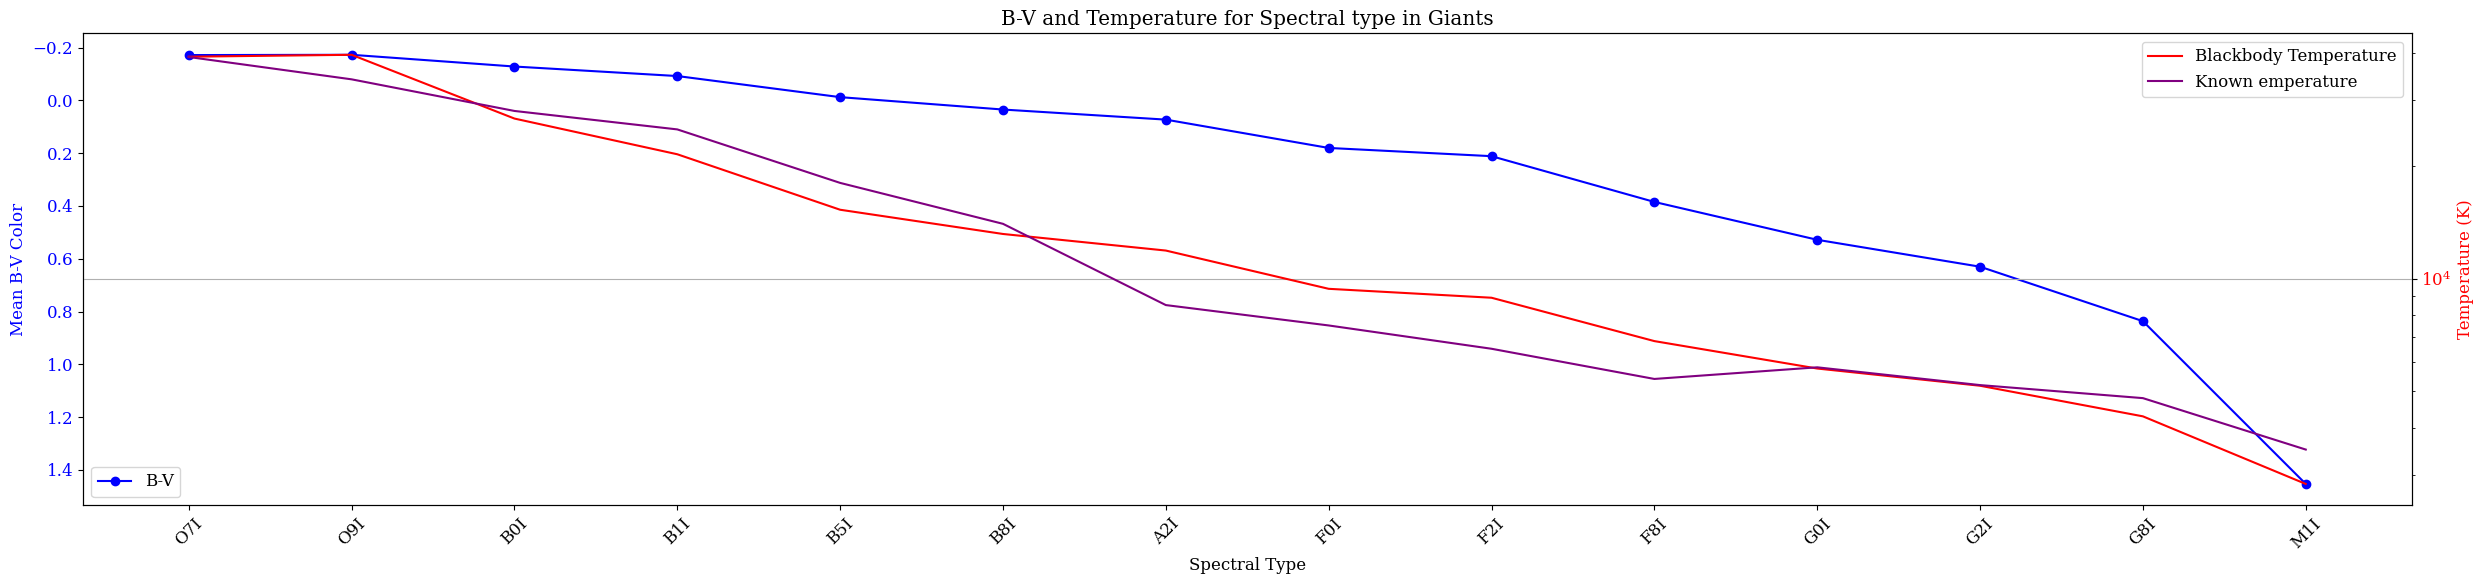

In [13]:
temperatures = []
for type in df_I['type']:
    type_BV= (df_I.loc[df_I['type'] == type, 'B-V'])
    type_BV = float(type_BV)
    #print(type_BV)
    # Find the row where the B-V value is closest to the A0V B-V value
    closest_index = (df_temp['B-V'] - type_BV).abs().idxmin()

    # Get the corresponding temperature
    closest_temperature = df_temp.loc[closest_index, 'Temperature']
    # Append the closest temperature to the list
    temperatures.append(closest_temperature)

# Assign the list of temperatures to a new column in df_V
df_I['temperature'] = temperatures

# Found online for our stars
temperatures_I = [39000, 34000, 28000, 25000, 18000, 14000, 8500, 7500, 6500, 5400, 5800, 5200, 4800, 3500]


# Create the figure and primary axis
fig, ax1 = plt.subplots(figsize=(25, 6))

# Plot magnitude on the left y-axis
ax1.plot(df_I['type'], df_I['B-V'], marker='o', linestyle='-', color='b', label='B-V')
ax1.set_xlabel('Spectral Type')
ax1.set_ylabel('Mean B-V Color', color='b')
ax1.tick_params(axis='y', labelcolor='b')  # Change y-axis tick color

# Invert the y-axis for magnitude
ax1.invert_yaxis()

ax2 = ax1.twinx()
ax2.plot(df_I['type'], df_I['temperature'], color='r', label='Blackbody Temperature')
ax2.plot(df_I['type'], temperatures_I, color='purple', label='Known emperature')
ax2.set_ylabel('Temperature (K)', color='r')
ax2.tick_params(axis='y', labelcolor='r')  # Change y-axis tick color
ax2.set_yscale('log')  # Set y-axis to logarithmic scale

# Add title and show legend
plt.title('B-V and Temperature for Spectral type in Giants')
ax1.legend(loc='lower left')
ax2.legend(loc='upper right')

ax1.set_xticks(range(len(df_I['type'])))  # Set tick positions
ax1.set_xticklabels(df_I['type'])  # Set tick labels

# Rotate the tick labels
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('pdf/mean_bv_temp_giant.pdf')
plt.show()

In [14]:
print(df_I['type'])



54    O7I
57    O9I
7     B0I
9     B1I
13    B5I
17    B8I
2     A2I
20    F0I
21    F2I
27    F8I
30    G0I
33    G2I
36    G8I
46    M1I
Name: type, dtype: object


In [4]:
print(len(spectra))

92
